In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
import statsmodels

/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df = pd.read_excel("System_combined.xlsx")
df.set_index("DateTime", inplace=True)
df.sort_index(ascending=True)
df = df.drop("Unnamed: 0", axis = 1)
df['systemPrice'].interpolate(method='time', inplace=True)
df.isna().sum()

/var/folders/cw/dgdk4x9j6fn07sqw2331qdhc0000gn/T/ipykernel_2991/916022138.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['systemPrice'].interpolate(method='time', inplace=True)


systemPrice    0
dtype: int64

## Tests for stationarity 

In [4]:
def adf_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print('Results of Augmented Dickey-Fuller Test:')
    adf_result = adfuller(timeseries)
    
    # Retrieve the p-value
    adf_pvalue = adf_result[1]
    
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_pvalue}')
    
    if adf_pvalue < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

def kpss_test(timeseries):
    from statsmodels.tsa.stattools import kpss
    print('\nResults of KPSS Test:')
    statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    
    # As the p-value is approximate, it should not be taken as an absolute measure of stationarity.
    if p_value < 0.05:
        print("The series is non-stationary.")
    else:
        print("The series is stationary.")



In [5]:

adf_test(df["systemPrice"]) #h0 can be rejected, there is  enough evidence that the timeseries is stationary
kpss_test(df["systemPrice"]) #h0 can be rejected, there is enough evidence that the timeseries is non-statinoary

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -9.577550489049935
p-value: 2.2025769433107834e-16
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 8.876045258727993
p-value: 0.01
The series is non-stationary.


/var/folders/cw/dgdk4x9j6fn07sqw2331qdhc0000gn/T/ipykernel_2991/1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


In [6]:

df["systemPricead"] = df["systemPrice"] + 30
df["systemPricelog"] = np.log(df["systemPricead"])



# Finding Parameters for ARIMA

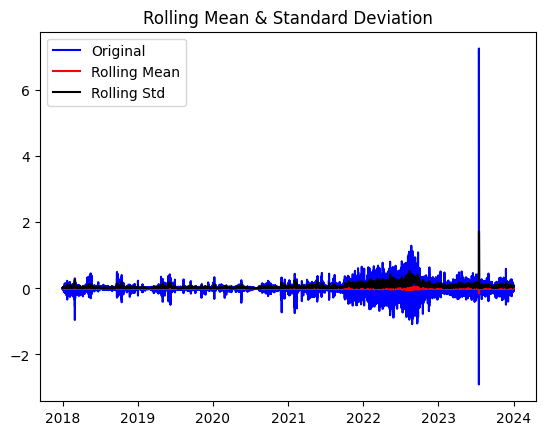

In [10]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

test_stationarity(df["systemPricelog"].diff().diff())
#adf_test(differenced_data)

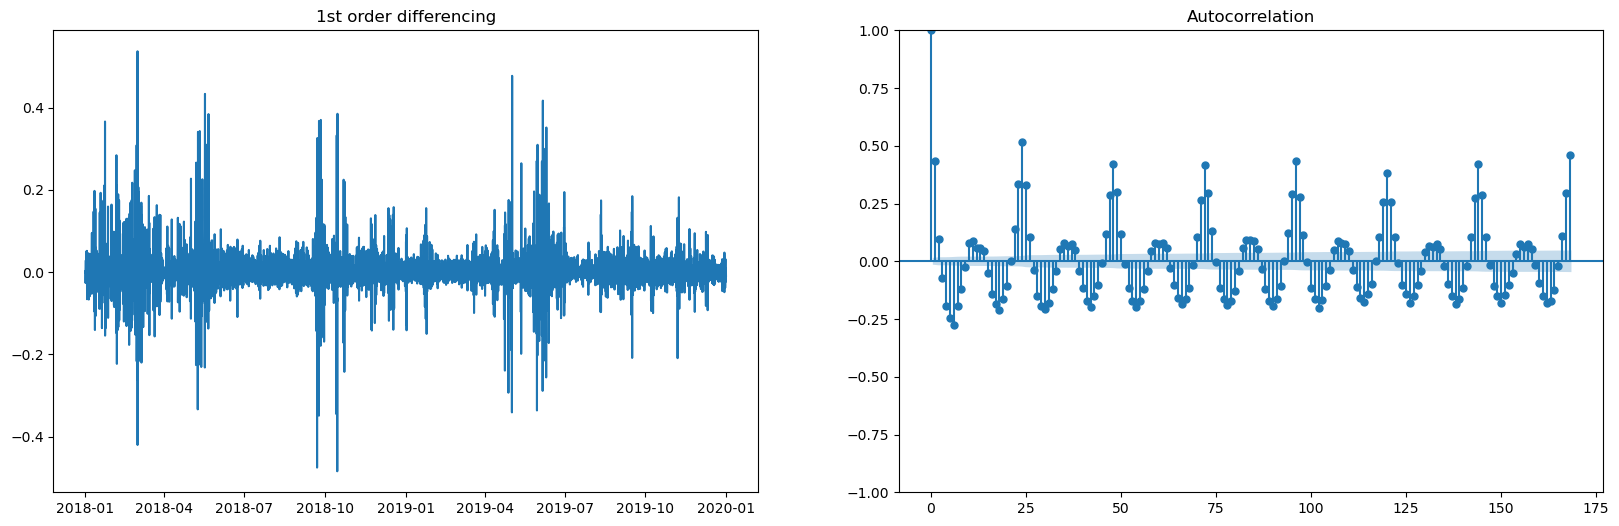

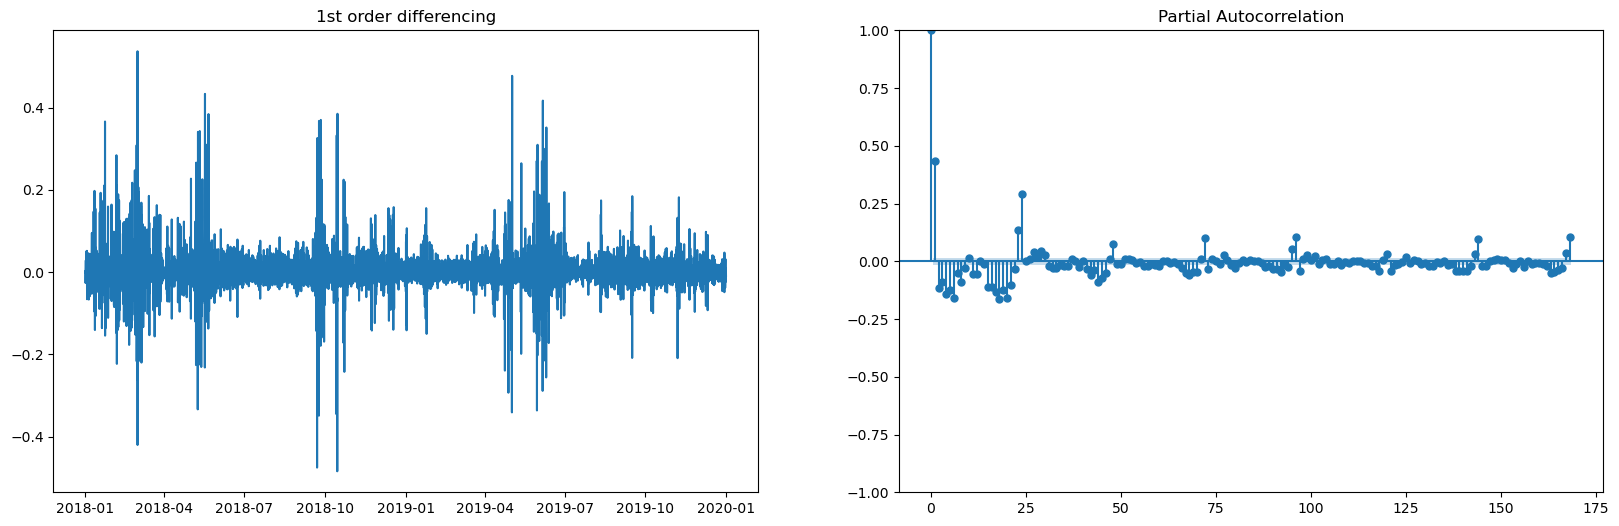

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -29.633639380806944
p-value: 0.0
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 0.06895440610306663
p-value: 0.1
The series is stationary.


/var/folders/cw/dgdk4x9j6fn07sqw2331qdhc0000gn/T/ipykernel_2991/1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
filtered_df = df["2018-01-01":"2019-12-31"]
# Assuming df["systemPrice"] is your data series.
differenced_data = filtered_df["systemPricelog"].diff().dropna()


# Set a wider figure size. For example, (20, 6) makes the figure 20 inches wide and 6 inches tall.
f = plt.figure(figsize=(20, 6))

# First subplot for the differenced data.
ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(differenced_data)

# Second subplot for the ACF plot.
ax2 = f.add_subplot(122)
plot_acf(differenced_data, lags=168, ax=ax2)
plt.show()

# Create another figure for the PACF plot, with the same figsize to keep consistency.
f = plt.figure(figsize=(20, 6))

ax1 = f.add_subplot(121)
ax1.set_title("1st order differencing")
ax1.plot(differenced_data)

ax2 = f.add_subplot(122)
plot_pacf(differenced_data, lags=168, ax=ax2)
plt.show()

adf_test(differenced_data)
kpss_test(differenced_data)



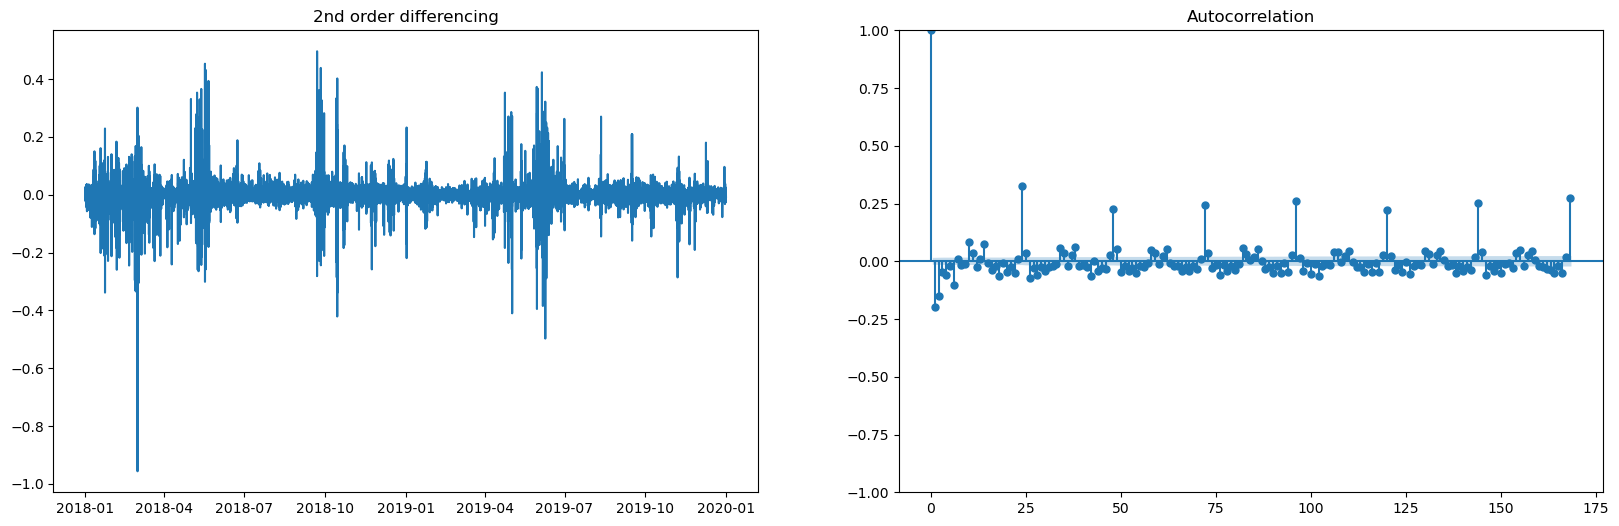

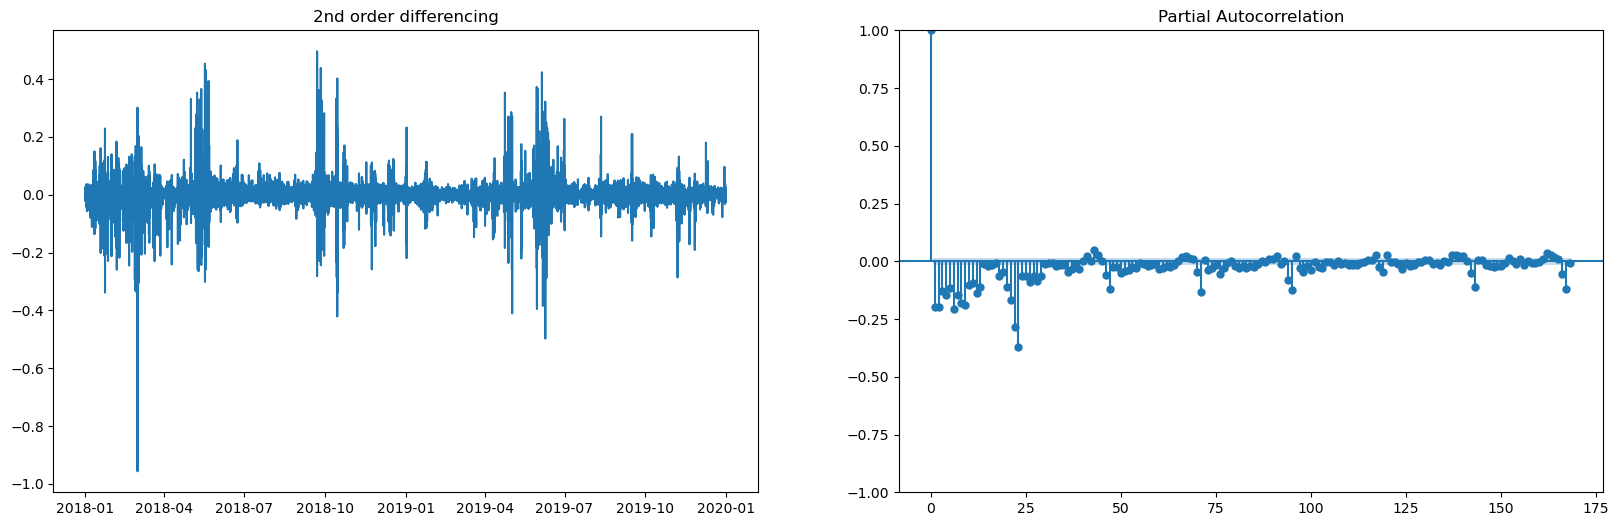

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming df["systemPrice"] is your data series.
differenced_data = filtered_df["systemPricelog"].diff().diff().dropna()

# Set a wider figure size. For example, (20, 6) makes the figure 20 inches wide and 6 inches tall.
f = plt.figure(figsize=(20, 6))

# First subplot for the differenced data.
ax1 = f.add_subplot(121)
ax1.set_title("2nd order differencing")
ax1.plot(differenced_data)

# Second subplot for the ACF plot.
ax2 = f.add_subplot(122)
plot_acf(differenced_data, lags=168, ax=ax2)
plt.show()

# Create another figure for the PACF plot, with the same figsize to keep consistency.
f = plt.figure(figsize=(20, 6))

ax1 = f.add_subplot(121)
ax1.set_title("2nd order differencing")
ax1.plot(differenced_data)

ax2 = f.add_subplot(122)
plot_pacf(differenced_data, lags=168, ax=ax2)
plt.show()

#adf_test(differenced_data)
#kpss_test(differenced_data)


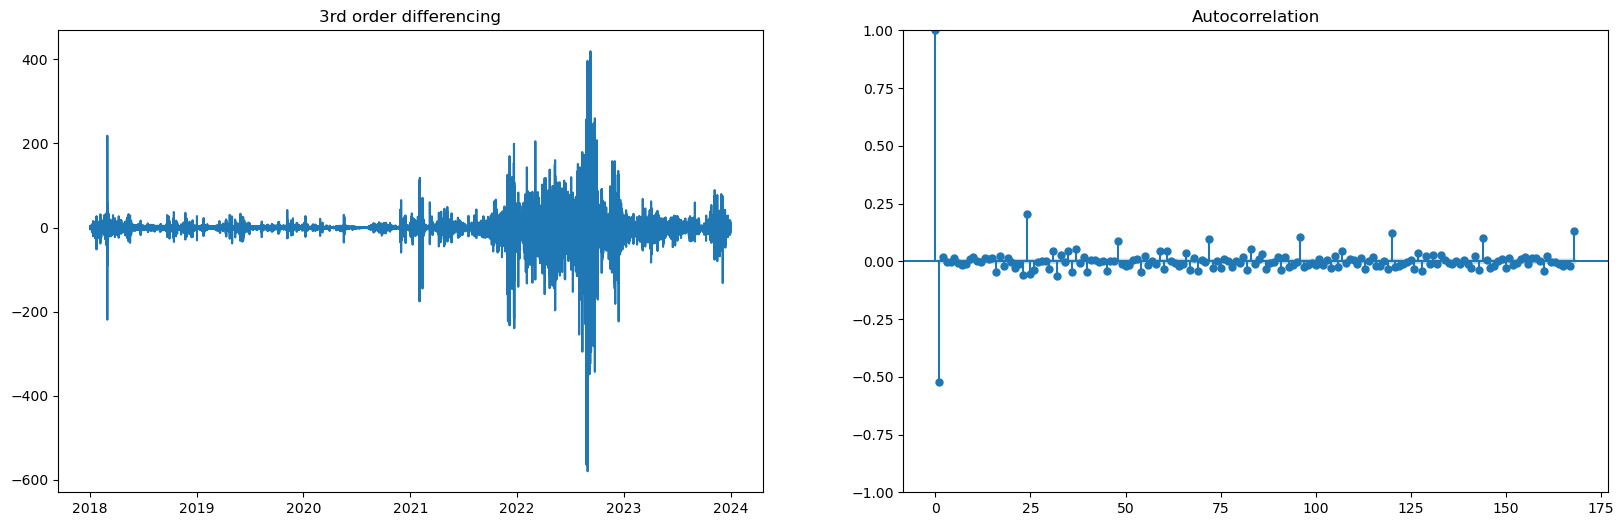

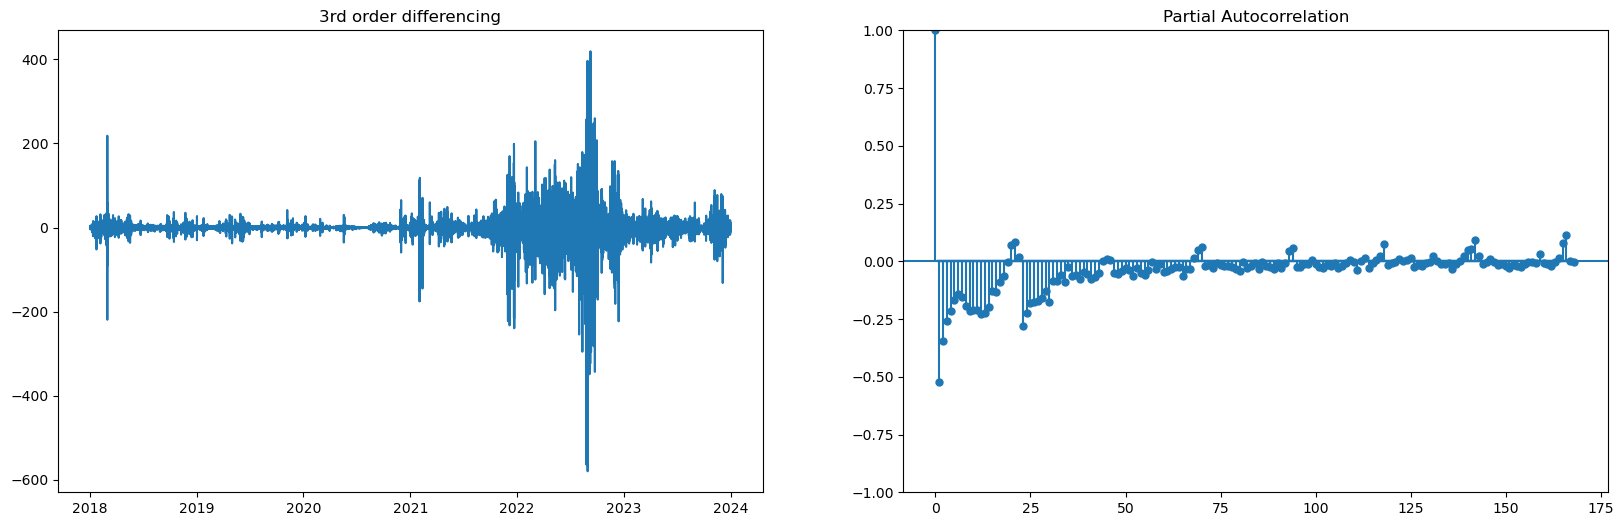

Results of Augmented Dickey-Fuller Test:
ADF Statistic: -68.0937825657236
p-value: 0.0
The series is stationary.

Results of KPSS Test:
KPSS Statistic: 0.037152616962754494
p-value: 0.1
The series is stationary.


/var/folders/cw/dgdk4x9j6fn07sqw2331qdhc0000gn/T/ipykernel_2991/1696104314.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(timeseries, 'c')


In [11]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming df["systemPrice"] is your data series.
differenced_data = filtered_df["systemPrice"].diff().diff().diff().dropna()

# Set a wider figure size. For example, (20, 6) makes the figure 20 inches wide and 6 inches tall.
f = plt.figure(figsize=(20, 6))

# First subplot for the differenced data.
ax1 = f.add_subplot(121)
ax1.set_title("3rd order differencing")
ax1.plot(differenced_data)

# Second subplot for the ACF plot.
ax2 = f.add_subplot(122)
plot_acf(differenced_data, lags=168, ax=ax2)
plt.show()

# Create another figure for the PACF plot, with the same figsize to keep consistency.
f = plt.figure(figsize=(20, 6))

ax1 = f.add_subplot(121)
ax1.set_title("3rd order differencing")
ax1.plot(differenced_data)

ax2 = f.add_subplot(122)
plot_pacf(differenced_data, lags=168, ax=ax2)
plt.show()

adf_test(differenced_data)
kpss_test(differenced_data)

In [ ]:
result = adfuller(filtered_df["systemPrice"].dropna())
print("p-value: ", result[1])
result = adfuller(filtered_df["systemPrice"].diff().dropna())
print("p-value: ", result[1])
result = adfuller(filtered_df["systemPrice"].diff().diff().dropna())
print("p-value: ", result[1])

## Trying to use the diff df and extracting seasonal component and trend being left with residuals

In [ ]:
# Re-importing the necessary libraries as the execution state was reset.
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

filtered_df = df["2023-01-01":"2023-12-31"]
decomposition = seasonal_decompose(filtered_df['systemPrice'], model='additive', period=24)

# This will extract the trend, seasonal, and residual components.
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
decomposition.plot()

# Show the plots
plt.show()

# Calculate rolling statistics
window = 24  # can be adjusted based on the dataset
rolmean = residual.rolling(window).mean()
rolstd = residual.rolling(window).std()

# Create a figure for the residuals and their rolling statistics
f = plt.figure(figsize=(20, 10))

ax1 = f.add_subplot(211)
ax1.set_title("Residuals with rolling mean and standard deviation")
ax1.plot(residual.dropna(), label='Original Residuals')
ax1.plot(rolmean, label='Rolling Mean', color= "red")
ax1.plot(rolstd, label='Rolling Std')
ax1.legend()

# Second subplot for the ACF plot.
ax2 = f.add_subplot(212)
plot_acf(residual.dropna(), lags=168, ax=ax2)





In [ ]:
#f = plt.figure()
#ax1 = f.add_subplot(121)
#ax1.set_title("residuals")
#ax1.plot(residual)

#ax2 = f.add_subplot(122)
#plot_acf(residual.dropna(), ax=ax2)
#plt.show()


#f = plt.figure()
#ax1 = f.add_subplot(121)
#ax1.set_title("Residuals")
#ax1.plot(residual)

#ax2 = f.add_subplot(122)
#plot_pacf(residual.dropna(), ax=ax2)
#plt.show()


f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1nd order differencing")
ax1.plot(residual)

ax2 = f.add_subplot(122)
plot_acf(residual.diff().dropna(), ax=ax2)
plt.show()


f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1nd order differencing")
ax1.plot(residual)

ax2 = f.add_subplot(122)
plot_pacf(residual.diff().dropna(), ax=ax2)
plt.show()



In [ ]:
adf_test(residual.dropna())
kpss_test(residual.dropna()) 


# ARIMA New

In [ ]:

# Using the to_frame() method
df = filtered_dfArima["systemPrice"].to_frame()

# Alternatively, using the DataFrame constructor
df = pd.DataFrame(filtered_dfArima["systemPrice"])
df.info()
# Using the to_frame() method

/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


/Users/mathiassperre/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:         systemPricelog   No. Observations:                17520
Model:                 ARIMA(2, 1, 3)   Log Likelihood               37214.403
Date:                Thu, 21 Mar 2024   AIC                         -74416.806
Time:                        17:22:39   BIC                         -74370.180
Sample:                    01-01-2018   HQIC                        -74401.453
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4872      0.011    136.847      0.000       1.466       1.509
ar.L2         -0.6422      0.009    -71.096      0.000      -0.660      -0.625
ma.L1         -1.1083      0.012    -95.809      0.0

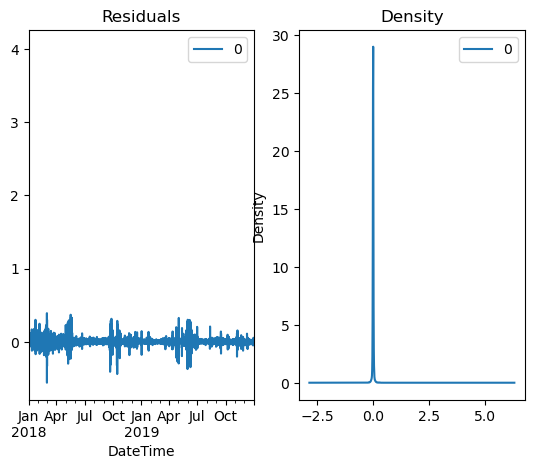

In [20]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt




# Choose the section of the dataframe that you want to model
#filtered_df = df["2023-6-01":"2023-12-01"]

# ARIMA Model parameters (p, d, q)
# These should be chosen based on your prior analysis, ACF, PACF, and stationarity tests
p = 2  # Replace with your chosen value
d = 1  # Replace with your chosen value, based on your earlier statement that no differencing is needed
q = 3  # Replace with your chosen value

# Fit the ARIMA model
model = ARIMA(filtered_df['systemPricelog'], order=(p, d, q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()




In [57]:
filtered_dfArima

,systemPrice,systemPricelog,systemPricead
DateTime,,,
2023-06-01 00:00:00,8.627994,3.653977,38.627994
2023-06-01 01:00:00,7.610175,3.627275,37.610175
2023-06-01 02:00:00,7.868988,3.634133,37.868988
2023-06-01 03:00:00,8.369181,3.647255,38.369181
2023-06-01 04:00:00,10.127232,3.692055,40.127232
...,...,...,...
2023-12-31 19:00:00,49.594203,4.376941,79.594203
2023-12-31 20:00:00,44.985186,4.317291,74.985186
2023-12-31 21:00:00,44.755875,4.314228,74.755875


In [74]:
df["systemPrice"] = df["systemPrice"] + 35
df["systemPrice"] = np.log(df["systemPrice"])
filtered_dfArima = df["2023-06-01":"2023-12-31"]
train_size = int(len(filtered_dfArima) * 0.8)
train, test = filtered_dfArima[0:train_size], filtered_dfArima[train_size:len(filtered_dfArima)]


## Working ARIMA, SUS

In [73]:
df = pd.read_excel("System_combined.xlsx")
df.set_index("DateTime", inplace=True)
df.sort_index(ascending=True)
df = df.drop("Unnamed: 0", axis = 1)
df['systemPrice'].interpolate(method='time', inplace=True)
df.isna().sum()

systemPrice    0
dtype: int64

Log transforming

In [65]:
df["systemPrice"] = df["systemPrice"] + 35
df["systemPrice"] = np.log(df["systemPrice"])


systemPrice    3.601017
dtype: float64

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#filtered_dfArima = df["2023-06-01":"2023-12-31"]
window_size = 24  # Size of the moving window

# Make sure to have enough data for the initial window plus one new point to predict
assert len(filtered_dfArima) >= window_size + 1

# Start the training set just with the size of the window
train, test = filtered_dfArima[:window_size], filtered_dfArima[window_size:]

order = (1, 2, 2)  # Example non-seasonal order
seasonal_order = (1, 1, 2, 24)  # Example seasonal order

history = train['systemPrice'].tolist()  # Initialize history with the training set
predictions = []

for t in range(len(test)):
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    
    # This is the forecasted value in log scale including the shift
    yhat_log = output[0]
    
    # Convert from log (with shift) back to original scale
    yhat_shifted = np.exp(yhat_log)
    yhat_original = yhat_shifted - 35  # subtract the shift to get the original value
    predictions.append(yhat_original)
    
    # Update history for the moving window
    obs_log = np.log(test.iloc[t]['systemPrice'] + 35)  # ensure to add 35 before taking log
    history.append(obs_log)
    history = history[-window_size:] 
# Convert predictions to a Series
predictions_series = pd.Series(predictions, index=test.index)


#88min 22.3s all years
#47min 2022-2023

In [72]:
actual_values

DateTime
2023-06-02 00:00:00    3.662649
2023-06-02 01:00:00    3.662487
2023-06-02 02:00:00    3.661923
2023-06-02 03:00:00    3.660533
2023-06-02 04:00:00    3.662113
                         ...   
2023-12-31 19:00:00    3.674726
2023-12-31 20:00:00    3.673305
2023-12-31 21:00:00    3.673232
2023-12-31 22:00:00    3.672986
2023-12-31 23:00:00    3.671699
Name: systemPrice, Length: 5112, dtype: float64

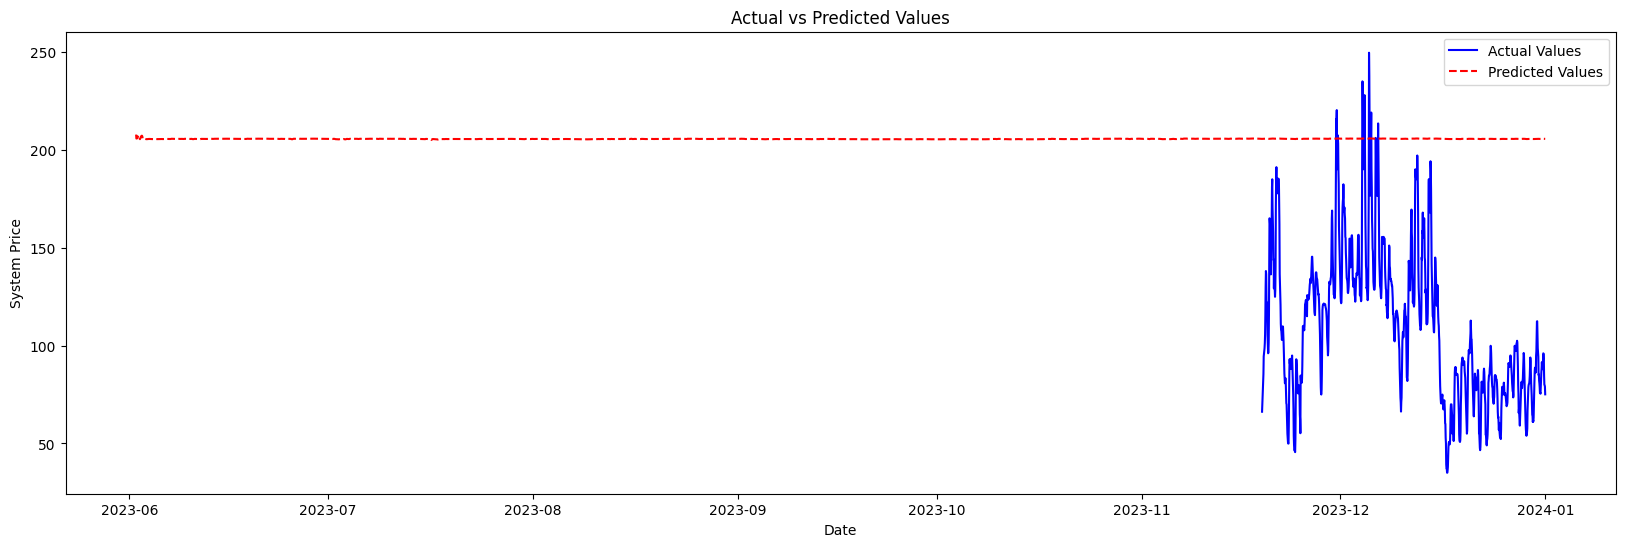

In [79]:
import matplotlib.pyplot as plt

# Assuming your actual values are in the `test` DataFrame under the 'systemPrice' column
actual_values = test["systemPrice"] + 35
actual_values = np.exp(test["systemPrice"])

# Ensure that the index of actual values and predictions aligns for correct plotting
#assert actual_values.index.equals(predictions_series.index)

# Plotting
plt.figure(figsize=(20, 6))  # Set the figure size for better readability
plt.plot(actual_values, color='blue', label='Actual Values')  # Plot actual values in blue
plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values')  # Plot predicted values in red with dashed lines
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('System Price')
plt.legend()
plt.show()


## RESULTS FROM MODEL FOR EASY IMPORT

In [ ]:
from joblib import dump, load

# Save model and predictions
#dump(model_fit, 'model_fit.joblib')
#dump(predictions_series, 'predictions_series.joblib')

#To LOAD RESULTS
model_fit = load('model_fit.joblib')
predictions_series = load('predictions_series.joblib')


## Accuracy Measure

In [70]:
import numpy as np

# Calculate RMSE
def calculate_rmse(actual, predicted):
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    return rmse

# Calculate MAE
def calculate_mae(actual, predicted):
    mae = np.mean(np.abs(actual - predicted))
    return mae

# Assuming `actual_values` and `predictions_series` are already defined
rmse = calculate_rmse(actual_values, predictions_series)
mae = calculate_mae(actual_values, predictions_series)


print(f"RMSE: {rmse}")
print(f"MAE: {mae}")



RMSE: 201.8095569090367
MAE: 201.809522324184


In [ ]:
forecast = results.get_forecast(steps=24,)
forecast_mean_log = forecast.predicted_mean

# Revert log-transformed forecast back to original scale by exponentiation
forecast_mean = forecast_mean_log

# Select the actual values from the test set for the first 24 hours and exponentiate to revert the transformation
actuals = test['systemPrice'][:24]

print(model_fit.summary())
# Plot the forecast alongside the actual values
plt.figure(figsize=(10, 5))
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red',)
plt.plot(actuals.index, actuals, label='Actual', color='blue')

plt.title('24-hour Forecast vs Actual')
plt.xlabel('Date Time')
plt.ylabel('System Price')
plt.legend()
plt.show()

In [ ]:
# Assuming 'test' is your DataFrame with the actual test data
# Assuming that 'test' index has the same datetime format as the 'train' DataFrame

# Predicting on the test set
# The 'dynamic=False' argument ensures that we produce one-step-ahead forecasts, 
# meaning that forecasts at each point are generated using the full history up to that point
predictions = results.get_forecast(steps=len(test.index))

# The forecast gives you several attributes; we want the predicted mean
predicted_mean = predictions.predicted_mean

# If the index of predictions does not align with the test set, align it manually
predicted_mean.index = test.index

# Convert predictions and actuals to the same scale if model was trained on log-transformed data
predicted_prices = predicted_mean
actual_prices = test['systemPrice']  # assuming the test set is not log-transformed

# Now we can calculate the APE, MAPE, and RMSE
ape = np.abs((actual_prices - predicted_prices) / actual_prices) * 100
mape = np.mean(ape)
rmse = np.sqrt(np.mean((actual_prices - predicted_prices) ** 2))

# Print the results
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



# STL Model

The ACF plot indicates that it still have some seasonality after detrending by shifting.Trying another approach: STL (Seasonal-Trend decomposition using Loess)

STL is flexible and allows for handling multiple seasonalities by breaking down the time series into three components:

Seasonal: Repeating short-term cycle in the series.,
Trend: Longer-term direction of the series.
Residual: The random variation left after extracting the seasonality and trend.

In [ ]:
#New STL Model test

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
#df["systemPrice_transformed"]
# Assuming 'df' and 'systemPrice' column setup
df.index = pd.to_datetime(df.index)

# Apply STL decomposition
#stl = STL(df["systemPrice_transformed"].dropna(), seasonal=365, period=24, robust = True)
stl = STL(df["systemPrice_transformed"].dropna(), seasonal=365, period=24, robust = True)  # Adjust 'seasonal' as needed
result = stl.fit()
result.plot()
plt.show()

# Subtract both trend and seasonal component to get residuals (stationary series)
df['systemPrice_transformed'] = result.resid

# Plot the stationary series
df['systemPrice_transformed'].dropna().plot(figsize=(8,4))
plt.title('Stationary Time Series')
plt.show()

adf_test(df['systemPrice_transformed'].dropna())
kpss_test(df['systemPrice_transformed'].dropna()) 


In [ ]:
min_value = 30
constant_to_add = abs(min_value) + 1

# Add the constant to the 'systemPrice' column and take the log
filtered_df['log_systemPrice'] = np.log(filtered_df["2023-01-01":"2023-03-01"] + constant_to_add)


## STL Period Check


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd

# Ensure the DataFrame index is recognized as a pandas datetime index
# This is crucial for proper filtering based on dates
df.index = pd.to_datetime(df.index)

# Filter the DataFrame for the specific date range
filtered_df = df["2023-01-01":"2023-03-01"]

# Apply STL decomposition to the filtered time series
stl = STL(filtered_df['log_systemPrice'], seasonal=7, period=24, robust = True)  # Assuming daily seasonality
res = stl.fit()

# Plot the decomposed components
fig = res.plot()

df['systemPrice_STL'] = res.resid

adf_test(df["systemPrice_STL"].dropna())
kpss_test(df["systemPrice_STL"].dropna()) 

In the code above, the STL function is initialized with the time series data and the period parameter is set to 24 for hourly data which indicates a daily seasonality. The seasonal parameter can be adjusted based on how smooth you want the seasonal component of your time series to be. A higher number makes the seasonal component smoother.

## continuing

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming 'residuals' is a pandas Series of numerical data containing the residuals of your STL model
# Ensure that 'residuals' are indeed floats and not strings
#residuals = residuals.astype(float)

# Apply the Ljung-Box test
lb_results = acorr_ljungbox(df["systemPrice_STL"], lags=[24], return_df=True)

# Print the results
print(lb_results)

# Check the p-value for significance
if lb_results['lb_pvalue'].iloc[0] < 0.05:
    print("The residuals are not white noise, indicating correlation in the data.")
else:
    print("The residuals are white noise, indicating no correlation.")



The Ljung-Box test results indicate a very high test statistic and a p-value of 0.0 for the residuals of your STL-decomposed series. This suggests that there is strong evidence of autocorrelation in the residuals at the first 10 lags.

When the Ljung-Box test statistic is significant (as in your case, where the p-value is effectively 0), this implies that the residuals are not independently distributed, and hence, they are not white noise. This could mean that there is still some structure left in your time series data that the STL decomposition did not fully capture, or there could be other dynamics at play that have not been accounted for.

In [ ]:
plot_acf(df["systemPrice_STL"].dropna(), lags=24)
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

plot_pacf(df["systemPrice_STL"].dropna(), lags=24)
plt.title('Autocorrelation Function (PACF) Plot')
plt.show()

